# Hackathon 02

## Imports

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import sqlalchemy

## CSV files

In [12]:
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

In [13]:
id_list = list(df_test.game_id.append(df_train.game_id))

## Website scraping

In [4]:
def scrape_hackathon_website(min_page_index=1, max_page_index=762):
    #parameters
    cols = ['index','Type','min_1','min_2','min_3','min_4','min_5','min_6','min_7','min_8','min_9','min_10','game_id']
    df = pd.DataFrame(columns=cols)

    base_url = 'https://ldsa-scrap-me.herokuapp.com/items?page='

    for page in range(min_page_index,max_page_index+1):
        # get raw html
        url = base_url+str(page)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
    
        # get text
        cast_list = soup.find_all('td', class_="align-middle")
        table_list = [i.get_text() for i in cast_list]
        text_list = [i for i in table_list if i != '']
    
        # append dataframe
        df_page = pd.DataFrame(np.array(text_list).reshape(-1,13),columns=cols)
        df = df.append(df_page)
        
        # print progress
        if page%25 == 0:
            print('scaped page {}/{}'.format(page,max_page_index))

    return df.set_index('index')

In [5]:
%%time
df_website = scrape_hackathon_website()
df_website.to_csv('data/df_website.csv')
#pd.read_csv('data/df_website.csv')

scaped page 10/762
scaped page 20/762
scaped page 30/762
scaped page 40/762
scaped page 50/762
scaped page 60/762
scaped page 70/762
scaped page 80/762
scaped page 90/762
scaped page 100/762
scaped page 110/762
scaped page 120/762
scaped page 130/762
scaped page 140/762
scaped page 150/762
scaped page 160/762
scaped page 170/762
scaped page 180/762
scaped page 190/762
scaped page 200/762
scaped page 210/762
scaped page 220/762
scaped page 230/762
scaped page 240/762
scaped page 250/762
scaped page 260/762
scaped page 270/762
scaped page 280/762
scaped page 290/762
scaped page 300/762
scaped page 310/762
scaped page 320/762
scaped page 330/762
scaped page 340/762
scaped page 350/762
scaped page 360/762
scaped page 370/762
scaped page 380/762
scaped page 390/762
scaped page 400/762
scaped page 410/762
scaped page 420/762
scaped page 430/762
scaped page 440/762
scaped page 450/762
scaped page 460/762
scaped page 470/762
scaped page 480/762
scaped page 490/762
scaped page 500/762
scaped pa

In [103]:
def tidy_up_gold_df(df):
    df = df.copy()\
           .pivot(index=['game_id'], columns='Type')\
           .astype(int)
    
    return df

def gold_lead_blue(df):
    # define teams
    blue_players = ['goldblueTop','goldblueJungle','goldblueMiddle','goldblueADC','goldblueSupport']
    red_players = ['goldredTop','goldredJungle','goldredMiddle','goldredADC','goldredSupport']
    
    # aggregate team gold
    blue_gold = df['min_10'][blue_players]\
                    .astype(int)\
                    .sum(axis=1)
    red_gold= df['min_10'][red_players]\
                    .astype(int)\
                    .sum(axis=1)
    
    # return team difference
    gold_lead_blue = blue_gold-red_gold
    return gold_lead_blue

In [152]:
def tidy_up_gold_df(df):
    df = df.copy()\
           .pivot(index=['game_id'], columns='Type')\
           .astype(int)
    return df

def gold_blue(df, minute=10):
    players = ['goldblueTop','goldblueJungle','goldblueMiddle','goldblueADC','goldblueSupport']
    gold = df['min_'+str(minute)][players]\
                    .astype(int)\
                    .sum(axis=1)
    return gold

def gold_red(df, minute=10):
    players = ['goldredTop','goldredJungle','goldredMiddle','goldredADC','goldredSupport']
    gold = df['min_'+str(minute)][players]\
                    .astype(int)\
                    .sum(axis=1)
    return gold

def final_gold_diff(df):
    blue = gold_blue(df,10)
    red = gold_red(df,10)
    diff = blue-red
    return diff

def all_gold_blue(df):
    gold = 0
    for minute in range(1,11):
        gold += gold_blue(df, minute=minute)
    return gold

def all_gold_red(df):
    gold = 0
    for minute in range(1,11):
        gold += gold_red(df, minute=minute)
    return gold

def last_earnings_blue(df):
    earnings = gold_blue(df, minute=10)-gold_blue(df, minute=9)
    return earnings

def last_earnings_red(df):
    earnings = gold_red(df, minute=10)-gold_red(df, minute=9)
    return earnings

def last_earnings_diff(df):
    blue = last_earnings_blue(df)
    red = last_earnings_red(df)
    diff = blue-red
    return diff

def blue_richer_count(df):
    count = 0
    for minute in range(1,11):
        count += gold_blue(df, minute=minute) > gold_red(df, minute=minute)
    return count

def generate_gold_features(df):
    features = pd.DataFrame()
    features['blue_gold'] = gold_blue(df)
    features['red_gold'] = gold_red(df)
    features['gold_diff'] = final_gold_diff(df)
    features['blue_richer'] = features['gold_diff'] >= 0
    features['blue_richer_count'] = blue_richer_count(df)
    features['blue_earn'] = last_earnings_blue(df)
    features['red_earn'] = last_earnings_red(df)
    features['earn_diff'] = last_earnings_diff(df)
    return features

In [155]:
df_gold_features = df_website.pipe(tidy_up_gold_df)\
                             .pipe(generate_gold_features)
df_gold_features.to_csv('data/df_gold_features.csv')

In [160]:
df_gold_features.corr()

,blue_gold,red_gold,gold_diff,blue_richer,blue_richer_count,blue_earn,red_earn,earn_diff
blue_gold,1.000000,0.208808,0.645808,0.481776,0.459980,0.511749,0.018804,0.350952
red_gold,0.208808,1.000000,-0.611819,-0.471558,-0.437031,0.025226,0.499159,-0.323446
gold_diff,0.645808,-0.611819,1.000000,0.757823,0.713238,0.394222,-0.374489,0.536376
blue_richer,0.481776,-0.471558,0.757823,1.000000,0.736088,0.274437,-0.283370,0.388902
blue_richer_count,0.459980,-0.437031,0.713238,0.736088,1.000000,0.139518,-0.141404,0.195893
blue_earn,0.511749,0.025226,0.394222,0.274437,0.139518,1.000000,-0.027626,0.729812
red_earn,0.018804,0.499159,-0.374489,-0.283370,-0.141404,-0.027626,1.000000,-0.703549
earn_diff,0.350952,-0.323446,0.536376,0.388902,0.195893,0.729812,-0.703549,1.000000


<AxesSubplot:xlabel='gold_diff', ylabel='earn_diff'>

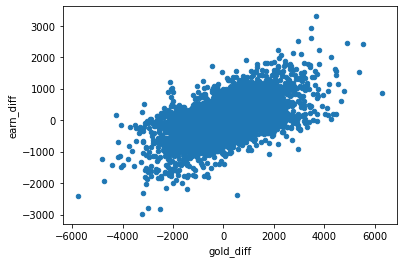

In [167]:
df_gold_features.plot.scatter('gold_diff', 'earn_diff')

## SQL

In [29]:
query = """ select t.game_id as game_id_towers, m.game_id as game_id_monsters, m."Team" as team_monsters, m."Time" as time_monsters, m."Team" as team_towers, t."Time" as time_towers
            from monsters m 
            full outer join towers t
            on m.game_id = t.game_id """

def query_hackathon_sql(query):    
    # Create an engine that allows to connect to the database
    username = 'ldsa_student'
    password = 'R4Fr4P3aAgMYBqqP'
    host_name = 'batch4-s02-db-instance.ctq2kxc7kx1i.eu-west-1.rds.amazonaws.com'
    port = 5432
    db_name = 'batch4_s02_db'
    schema = 'hackathon_students'
    conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)
    conn_args = {'options': '-csearch_path={}'.format(schema)}
    engine = sqlalchemy.create_engine(conn_str, connect_args=conn_args)
    # Reading the query and put the result into a DataFrame
    df = pd.read_sql_query(query, engine)
    return df

In [32]:
df_sql = query_hackathon_sql(query)

In [33]:
df_sql

,game_id_towers,game_id_monsters,team_monsters,time_monsters,team_towers,time_towers
0,5f86d932-465d-4278-8f2c-e837398c696e,None,None,NaN,None,6.378
1,4b4c0c9f-62e2-44ea-a2fe-aa4c59a182b6,4b4c0c9f-62e2-44ea-a2fe-aa4c59a182b6,rDragons,8.246,rDragons,8.946
2,3beaa8b3-6263-47c9-85fa-8dde611f0bb6,3beaa8b3-6263-47c9-85fa-8dde611f0bb6,rDragons,9.551,rDragons,8.960
3,9dcadc3c-7c30-4773-af55-a73edb4cf589,None,None,NaN,None,10.332
4,3ca49512-a10f-472a-8c15-3bb67d6dbed3,3ca49512-a10f-472a-8c15-3bb67d6dbed3,rDragons,10.630,rDragons,8.743
...,...,...,...,...,...,...
9721,None,b14d0500-6098-4a3e-931f-3a6ed2452946,rDragons,10.711,rDragons,NaN
9722,None,9ae9a448-7df2-4435-8ba6-c7feabb977af,bDragons,10.716,bDragons,NaN
9723,None,727b1523-0c69-4bad-ac71-358725980e6c,rDragons,9.204,rDragons,NaN
9724,None,5f102608-22c8-41e7-a0ea-2fb3ff6c9bf9,rDragons,10.453,rDragons,NaN


In [157]:
df_sql.team_towers.unique()

array([None, 'rDragons', 'bDragons', 'bHeralds', 'rHeralds'], dtype=object)

<AxesSubplot:>

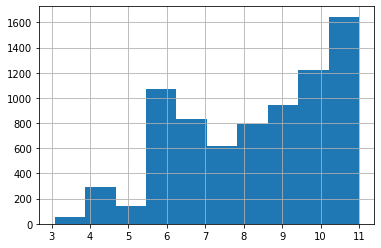

In [158]:
df_sql.time_monsters.hist()